<a href="https://colab.research.google.com/github/WittyTheMighty/Intro-to-RL/blob/main/Bandit_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Assignement 1***

Julien Witty <br>
1949837 <br>
Polytechnique Montreal
-------------------
**1 Bandit Problem** <br>
Consider the 10-armed testbed (Sutton & Barto, 2018, Section 2.3), which is a set of n
randomly generated 10-armed bandit problems. For each bandit problem, the action values,
q∗(a), a=1,...,10, are selected according to a normal (Gaussian) distribution with mean 0
and variance 1. When a learning method selects action At at time t, the actual reward, Rt
,
is selected from a normal distribution with mean q∗(At) and variance 1. For this question,
consider the number of independent runs n=20, each run consists of 1000 pulls.

1. Create a class for the bandit, which contains a function pull that takes the action as
the input and returns the reward.

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:

print(1e-5)

input= [200 , 4,5,2,5,6,3,1,1.4,2.7]
  
P = np.exp(input)/np.sum(np.exp(input))
print(P)
np.ones(10)/10
n= np.arange(10)

a= np.random.choice([0,1,2,3,4,5,6,7,8,9],p=P)
print("a: ", a)

1e-05
[1.00000000e+00 7.55581902e-86 2.05388455e-85 1.02256891e-86
 2.05388455e-85 5.58303706e-85 2.77963048e-86 3.76182078e-87
 5.61197715e-87 2.05920091e-86]
a:  0


In [ ]:



class Bandit:

    # q_star : Theoric value of Q
    # epsillon : Exploratory frequency
    # action_counter: keeping track of the number of step for each action 
    # step_reward: reward history given at step n
    
    def __init__(self,q_start,epsillon = 0.1, optimistic = 0, ucb_val = None, baseline_is_average = True,alpha = 0):
        self.q_star = q_start
        self.epsillon = epsillon
        self.action_counter = np.zeros(10)
        self.action_value = np.zeros(10) + optimistic
        self.step_reward = []
        self.q_history = []
        self.regret_history = []
        self.optimistic = optimistic
        self.avg_reward = 0
        self.stepsize = alpha
        self.baseline_is_average = baseline_is_average
        self.c = ucb_val
        #add number 10
        self.H = np.zeros(10)
        self.avg_reward_history = []
        self.indices = np.arange(10)

        self.cum_reward = 0
        
        
    def pull(self,action) -> float:
        return  np.random.normal(action)


    def regret(self,timestep):
        regret = timestep * self.q_star[np.argmax(self.q_star)] - self.cum_reward
        self.regret_history.append(regret)


    def bandit(self,action_idx:int):
            self.action_counter[action_idx] = self.action_counter[action_idx] +1
            reward = self.pull(self.q_star[int(action_idx)])
            self.cum_reward += reward
            return reward,self.action_counter[action_idx]
    def e_greedy(self):
        #We want to do n pull
        for pull in range(0,1000):
            if  np.random.rand() >  self.epsillon :
                          
            #We will need to change this for random allocation with tie breaker.
                Q_idx = self.random_argmax(self.action_value)
                reward,n = self.bandit(int(Q_idx)) 
                self.action_value[Q_idx] = self.action_value[Q_idx] + 1/n * (reward - self.action_value[Q_idx])
                #each row correspond to a step pull
                self.step_reward.append(reward)
                self.q_history.append(self.action_value[Q_idx])
                self.regret(pull)
            else:
                Q_idx = int(np.round(np.random.rand()*100 % 9))
                reward,n = self.bandit(Q_idx)
                self.action_value[Q_idx] = self.action_value[Q_idx] + 1/n * (reward - self.action_value[Q_idx])   
                self.step_reward.append(reward)
                self.q_history.append(self.action_value[Q_idx])
                self.regret(pull)
            self.avg_reward = self.avg_reward + 1/(pull+1)*(reward - self.avg_reward)
            self.avg_reward_history.append(self.avg_reward)
    def ucb(self):
        for pull in range(0,1000):
            # (self.action_count + 1e-9)) : easy way to avoid division per 0 without a lot of impact
            # np.log(n + 1) to avoid log 0 error
            ucb_value = self.action_value + self.c * np.sqrt(np.log(pull + 1) / (self.action_counter + 1e-9))
            Q_idx  = self.random_argmax(ucb_value)
            reward,n = self.bandit(int(Q_idx)) 
            self.action_value[Q_idx] = self.action_value[Q_idx] + 1/n * (reward - self.action_value[Q_idx])
            #each row correspond to a step pull
            self.step_reward.append(reward)
            self.q_history.append(self.action_value[Q_idx])
            self.regret(pull)
            self.avg_reward = self.avg_reward + 1/(pull+1)*(reward - self.avg_reward)
            self.avg_reward_history.append(self.avg_reward)
    def gradient(self):

        for pull in range(1000):
            softmax_array = self.softmax(self.H)
            action_idx = np.random.choice(self.indices, p=softmax_array)
            # print("Action_idx : ",action_idx, " Softmax array: ", softmax_array)
            reward,n = self.bandit(action_idx)
    
            self.avg_reward = self.avg_reward + 1/(pull+1)*(reward - self.avg_reward)
            self.action_value[action_idx] = self.action_value[action_idx] + 1/n * (reward - self.action_value[action_idx])
            self.avg_reward_history.append(self.avg_reward)
            baseline = 0
            if self.baseline_is_average:
                baseline = self.avg_reward
        

            for idx, preference in enumerate(self.H):
                # print("idx ",  idx)
                if action_idx == idx:
                    # print("Increment preference, baseline: ", baseline)
                    self.H[idx] += self.stepsize*(reward-baseline)*(1-softmax_array[idx])
                else:
                    # print("decrement preference")
                    self.H[idx] -= self.stepsize*(reward-baseline)*(softmax_array[idx])
            # print("temp_H", temp_H)
            self.step_reward.append(reward)
            self.q_history.append(self.action_value[action_idx])
            self.regret(pull)

        
    #Utility function: 

    #Remove tie breaker
    def random_argmax(self,value_list):
        return np.argmax(np.random.random(np.asarray(value_list).shape) * (value_list==value_list.max()))

    def softmax(self, input):
        softmax_array = np.exp(input)/np.sum(np.exp(input))
        return softmax_array

        


In [ ]:
#To be comparable we start with the same actions otherwise there is too much variability between result
#We want to compare similaire thing at first.
actions = np.random.normal(size=10)
n = 20
epsillons = [0, 0.01, 0.1]
bandits = [Bandit(actions,0) for i in range(n)]


In [ ]:
#@title
#Plotting with n run:

#
def bandit_testbed(q_star_actions_value, epsillon,n,optimistic = 0):
    bandits = [Bandit(q_star_actions_value,epsillon,optimistic) for i  in range(n)]
    for bandit in bandits:
        bandit.e_greedy()
    np_avg_reward = np.array([bandit.avg_reward_history for bandit in bandits])
    np_avg_regret = np.array([bandit.regret_history for bandit in bandits])
    np_avg_q_history = np.array([bandit.q_history for bandit in bandits])

    
    np_mean_reward  = np.mean(np_avg_reward, axis =0)
    np_mean_regret = np.mean(np_avg_regret, axis =0)
    np_mean_q = np.mean(np_avg_q_history, axis =0)
    return [np_mean_reward , np_mean_regret,np_mean_q]

# plt.plot([x for x in range(1000)],avg_reward)
normal_array = (np.random.normal(size=10))
a = bandit_testbed(normal_array,0.1,20,3)
b= bandit_testbed(normal_array,0.1,20,0)

0.1
0.01
0


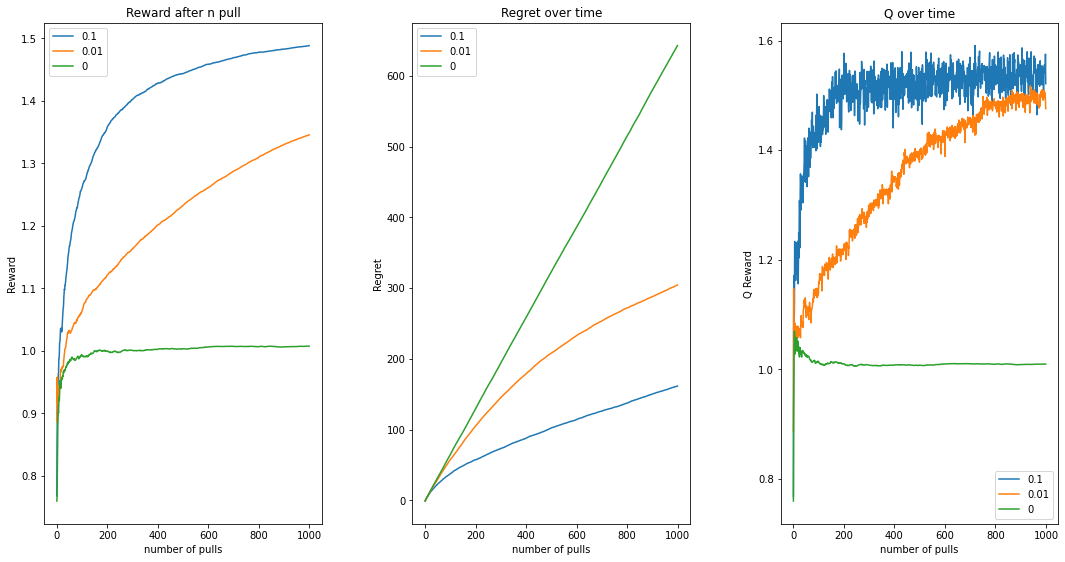

In [ ]:
import copy
#We need to deepcopy the elements otherwise the reference are kept between test.
#Number of run
n = 200
epsillons = [0.1,0.01, 0]
def reward_step_graph(epsillons,n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
    avg_rewards = []
    actions_value = (np.random.normal(size=10))
    for epsillon in epsillons:
        avg_rewards.append(bandit_testbed(copy.deepcopy(actions_value),epsillon,n))

    for rewards,epsillon in zip(avg_rewards, epsillons):
        print(epsillon)
        ax1.plot([x for x in range(1000)],rewards[0],label =epsillon)
        ax2.plot([x for x in range(1000)],rewards[1],label =epsillon)
        ax3.plot([x for x in range(1000)],rewards[2],label =epsillon)

    ax1.set_title("Reward after n pull")
    ax1.set(xlabel = "number of pulls", ylabel = "Reward" )
    ax2.set_title("Regret over time")
    ax2.set(xlabel = "number of pulls", ylabel = "Regret" )

    ax3.set_title("Q over time")
    ax3.set(xlabel = "number of pulls", ylabel = "Q Reward" )
    legend1 = ax1.legend()
    legend2 = ax2.legend()
    legend2 = ax3.legend()
    
    fig.tight_layout(pad=5.0)

reward_step_graph(epsillons,n)

> #  **2.** The figure above show the result of e-greedy algorithm after $n=2000$ We can see that the learning rate of $\epsilon = 0$ is bad because there is no exploratory step.  $\epsilon = 0.1$ have an faster learning rate then $\epsilon = 0.01$. This can be clearly seen with the regret curves. The regret of the orange curve goes higher then the blue one. This is because we don't give enough exploratory steps.

0
0.9


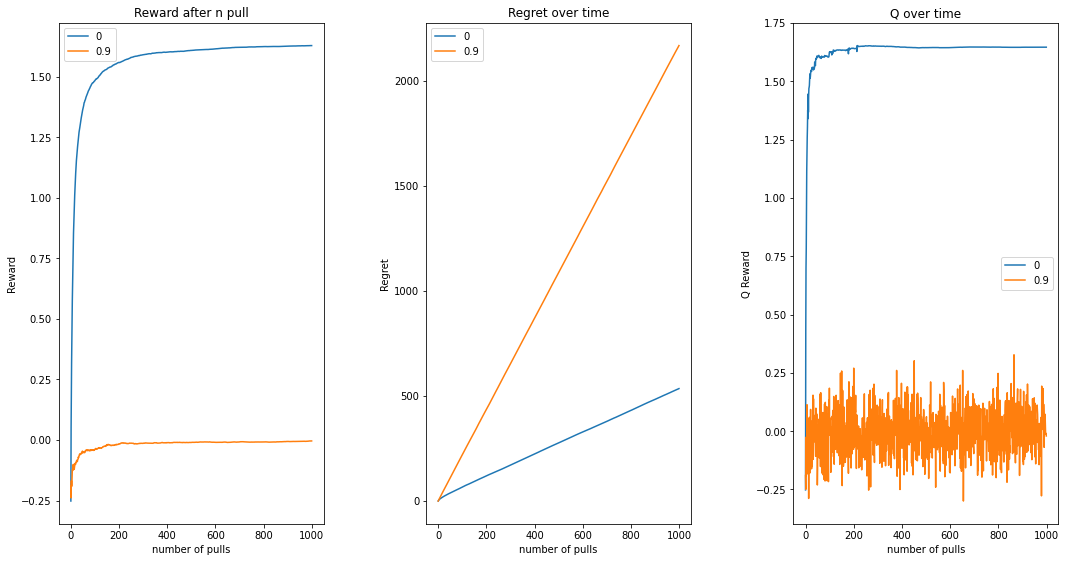

In [ ]:
reward_step_graph([0,0.9],n)

#3.In the figure above we see the orange curve have a much higher regret value then the worst $\epsilon$-greedy case. This is because the algorithm is always exploring new states and only taking the best 10% of the time.This can be clearly see in the figure with Q over time where the value at each step are distributed around 0.

[-0.49119657 -0.56828121  0.23898495  1.04764531  0.09957552 -1.48450213
 -0.07324806  1.39349803  0.50046181  1.14969962]


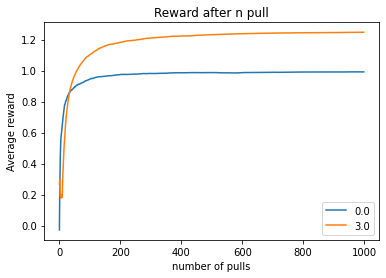

In [ ]:
optimistic = [0.0, 3.0]

def optimistic_initial_value(n,epsillon, optimistic):

    avg_rewards = []
    actions_value = (np.random.normal(size=10))
    print(actions_value)
    for optimistic_value in optimistic:
        avg_rewards.append(bandit_testbed(copy.deepcopy(actions_value),epsillon,n,optimistic_value))
    for rewards,optimistic_value in zip(avg_rewards, optimistic):
        plt.plot([x for x in range(1000)],rewards[0],label = optimistic_value)
    plt.title("Reward after n pull")
    plt.xlabel("number of pulls")
    plt.ylabel("Average reward")
    plt.legend()

optimistic_initial_value(n,0,optimistic)

# 4. The figure above show that the optimistic clearly improve the learning rate. The orange curve converge on an higher value. This is because the optimistic value gave the chance to explore all the states before.  Afterwards it is taking the best. In this case, the result are very good because the variance is relatively small. 

[-0.94191591  1.37248983 -0.55683021  1.10682588 -1.09592421  0.24159511
  0.75650684  1.28474153 -1.47689057  0.37696177]


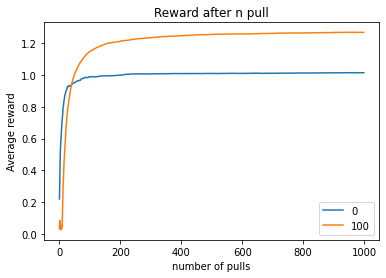

In [ ]:
optimistic_initial_value(n,0,[0,100])

# > 5. They are not a lot of difference between the optimistic value of 3 and 100. The optimistic value of 100 will only take longer to stabilize.

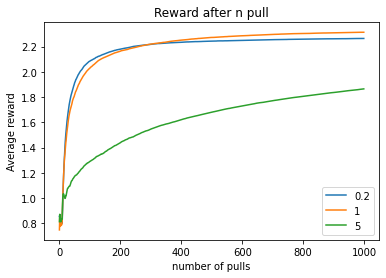

In [ ]:
c = [0.2,1,5]

def ucb_testbed(q_star_actions_value, epsillon,n,c):
    bandits = [Bandit(q_star_actions_value,epsillon, ucb_val=c) for i  in range(n)]
    for bandit in bandits:
        bandit.ucb()
    np_avg_reward = np.array([bandit.avg_reward_history for bandit in bandits])
    np_avg_regret = np.array([bandit.regret_history for bandit in bandits])
    np_avg_q_history = np.array([bandit.q_history for bandit in bandits])

    
    np_mean_reward  = np.mean(np_avg_reward, axis =0)
    np_mean_regret = np.mean(np_avg_regret, axis =0)
    np_mean_q = np.mean(np_avg_q_history, axis =0)
    return [np_mean_reward , np_mean_regret,np_mean_q]

def ucb_plotting(n,epsillon, ucb_val):

    avg_rewards = []
    actions_value = (np.random.normal(size=10))
    for ucb_val in c:
        avg_rewards.append(ucb_testbed(copy.deepcopy(actions_value),epsillon,n, ucb_val ))
    for rewards,c_val in zip(avg_rewards, c):
        plt.plot([x for x in range(1000)],rewards[0],label = c_val)
    plt.title("Reward after n pull")
    plt.xlabel("number of pulls")
    plt.ylabel("Average reward")
    plt.legend()

    
ucb_plotting(n, 0, c)


# 6. The figure above show the UCB plot. Here you can see that the c value has a big impact on the result. The c= 5 is learning much slower then the value 0.2 and 1. The value c = 5 has a little spike in the beginning. The orange curve is better overtime

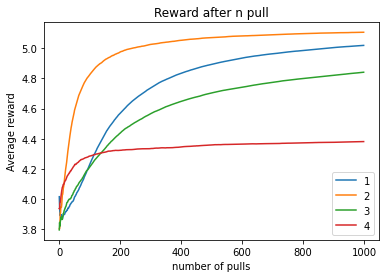

In [ ]:

n = 2000
def gradient_testbed(q_star_actions_value,baseline_is_average,alpha,n=200):
    bandits = [Bandit(q_star_actions_value, baseline_is_average= baseline_is_average, alpha = alpha) for i  in range(n)]
    for bandit in bandits:
        bandit.gradient()
    np_avg_reward = np.array([bandit.avg_reward_history for bandit in bandits])
    np_avg_regret = np.array([bandit.regret_history for bandit in bandits])
    np_avg_q_history = np.array([bandit.q_history for bandit in bandits])

    
    np_mean_reward  = np.mean(np_avg_reward, axis =0)
    np_mean_regret = np.mean(np_avg_regret, axis =0)
    np_mean_q = np.mean(np_avg_q_history, axis =0)
    return [np_mean_reward , np_mean_regret,np_mean_q]


baseline = [True,True,False,False]
stepsize = [ 0.1, 0.5, 0.1, 0.5]
def gradient_plotting(n,baseline, stepsize):
    avg_rewards = []
    actions_value = (np.random.normal(4,size=10))
    for baseline,stepsize in zip(baseline,stepsize):
        avg_rewards.append(gradient_testbed(copy.deepcopy(actions_value),baseline, stepsize))
    for rewards,test_number in zip(avg_rewards, [1,2,3,4]):
        plt.plot([x for x in range(1000)],rewards[0],label = test_number)
    plt.title("Reward after n pull")
    plt.xlabel("number of pulls")
    plt.ylabel("Average reward")
    plt.legend()

gradient_plotting(n,baseline,stepsize)


#7. The figure above show the gradient curves with the require conditions. The baseline is helping the learning rate. This is because when a bad step is taken it is weigthed down. Moreover, we can see that a stepsize value a little bit higher improve the regret since it's penalizing wrong action faster.

#The result follows what have been expected.

[0.1]
1


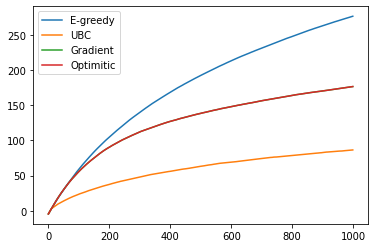

In [ ]:
def regretComparison(baseline,stepsize,c,epsillons,optimistic):
    n=2000
    actions_value = (np.random.normal(4,size=10))
    # e-greedy 
    average_reward_greedy = []
    for epsillon in epsillons:
        average_reward_greedy.append(bandit_testbed(copy.deepcopy(actions_value),epsillon,n))

    # UCB
    ucb_rewards = []
    for ucb_val in c:
        ucb_rewards.append(ucb_testbed(copy.deepcopy(actions_value),epsillon,n, ucb_val ))      
    # Gradients
    gradient_reward = []
    print(stepsize)
    for baseline,stepsize in zip(baseline,stepsize):
        gradient_reward.append(gradient_testbed(copy.deepcopy(actions_value),baseline, stepsize,n))
    optimistic_reward = []
    optimistic_reward.append(bandit_testbed(copy.deepcopy(actions_value),0,n,optimistic=optimistic[0]))

    plt.plot([x for x in range(1000)],average_reward_greedy[0][1],label = "E-greedy")
    plt.plot([x for x in range(1000)],ucb_rewards[0][1],label = "UBC")
    plt.plot([x for x in range(1000)],gradient_reward[0][1],label = "Gradient")
    plt.plot([x for x in range(1000)],gradient_reward[0][1],label = "Optimitic")
    print(len(gradient_reward))
    plt.legend()

epsillons = [0.01]
c = [1]
baseline = [True]
stepsize = [ 0.1]
optimistic = [3]    
regretComparison(baseline,stepsize,c,epsillons,optimistic)      

# 8. Here we see that E-greedy has the highest regret value. UCB has the lowest regret value. The gradient and the optimistic test are better then e-greedy are overlapping each other which is a little. The UCB suprisingly a fast learning rate compare to the other methods. According to our result it is the best method to use for the bandit problem.

## I was supprise to see that the gradient and optimistic value where giving the same curve. The regret between the two steps is not much different.

##2 Dynamic Programming
Consider the tabular environment of 5x5 Gridworld. The nonterminal states are S={1,2,...,22,23}.
There are four actions possible in each state, A={up, down, right, left}, which deter-
ministically cause the corresponding state transitions, except that actions that would take
the agent o the grid in fact leave the state unchanged. This is an undiscounted, episodic
task. The reward is −1 on all transitions until the terminal state is reached. The terminal
state is shaded in the figure (although it is shown in two places, it is formally one state).
Suppose the agent follows the equiprobable random policy (all actions equally likely). Thus,
for instance, p(6 -1|5, right)=1, p(12,-1 | 5, right)=0.
1. if $\pi$ is the equiprobable random policy, what is $q_{\pi}(11, down)$? What is $q_{\pi}(7, down)$?

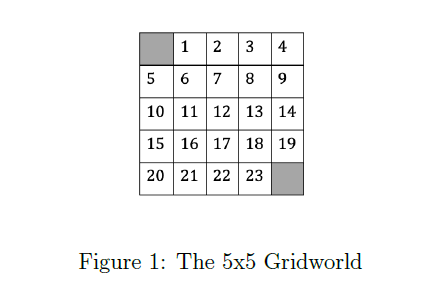

In [ ]:
def go_south(idx, size,length):

    if idx == 0 or idx == length-1:
        return idx
    if  ((idx) // size > size-1):
        return idx
    return int(idx +size)

go_south(1,4,16)


5

To achieve this question we need to use the iterative policy evaluation, for estimating $V \approx \nu_{\pi} $

In [ ]:
import copy
#Iterative policy evaluation for squared Gridworld problem

#Moving in the action direction, returning the current state index:

def go_north(idx, size,length):
    if idx == 0 or idx == length-1:
        return idx
    if not ((idx+1) // size and (idx+1) != size):
        return idx
    return int(idx  - size)

def go_east(idx, size,length):
    if idx == 0 or idx == length-1:
        return idx
    if not ((idx+1) % size):
        return idx
    return int(idx +1)

def go_west(idx, size,length):
    if idx == 0 or idx == length-1:
        return idx
    if not (idx % size):
        return idx
    return int(idx -1)

def go_south(idx, size,length):
    if idx == 0 or idx == length-1:
        return idx
    if  ((idx) // size >= size-1):
        return idx
    return int(idx +size)

def action_reward_value(old_grid, index):
    length = len(old_grid)
    size = np.sqrt(length)
    return 0.25*(old_grid[go_south(index, size,length)]-1 + old_grid[go_north(index, size,length)]-1 + old_grid[go_west(index, size,length)]-1 + old_grid[go_east(index, size,length)]-1)


# Since the problem is fairly simple to model we are just going to use one function.
def gridworld_policy_evaluation(size,terminal_state_pos,reward, threshold):

    #Initiliaze the grid
    dim = size * size
    #Another version of the algorithm use one array.
    gridword_current_value = np.zeros(dim)
    gridword_old_value = np.zeros(dim)
    
    #Threshold  value for breaking loop. Consider to be converged aster 0.001 since the reward if much higher
    theta = threshold
    state_action_policy_probability = 0.25
    delta = 1000
    iteration = 0
    while delta > theta:
        delta = 0
        #Probability of choosing an action is the same
        gridword_old_value = copy.deepcopy(gridword_current_value)
        for idx, action in enumerate(gridword_old_value):
            
            gridword_current_value[idx] = action_reward_value(gridword_old_value,idx)
            #Reset terminal to 0
        for terminal_idx in terminal_state_pos:
            gridword_current_value[terminal_idx] = 0
        grid_delta = np.abs(gridword_current_value - gridword_old_value)
        delta = grid_delta[np.argmax(grid_delta)]
        iteration+=1
    print("Convergence at",iteration," iterations")
    return gridword_current_value

# a= [0, -1 , -1 ,-1, -1 , -1, -1, -1,-1 ,-1,-1,-1]
# print(action_reward_value(a,1))

t = [0,15]
gridworld_policy_evaluation(4,t,-1,0.001)






Convergence at 131  iterations


array([  0.        , -13.98945772, -19.98437823, -21.98251832,
       -13.98945772, -17.98623815, -19.98448273, -19.98437823,
       -19.98437823, -19.98448273, -17.98623815, -13.98945772,
       -21.98251832, -19.98437823, -13.98945772,   0.        ])

In the result over you can see the converging values of the 5x5 grid.

In [ ]:
import copy
import numpy as np
import random


class State:
    
    def __init__(self,id,size,reward = -1, terminal = False):
        self.value = 0
        self.id = id
        self.size = size
        self.length = size*size
        self.is_terminal = terminal
        self.reward = -1
        self.visited_counter = 0
        self.size = size
        self.state_policy = [1 for i in range(4) ]
        self.neighbours = self.adjacent_state(id)

    def update_value(self,value):
        self.value = value
    def isVisited():
        self.visited_counter += 1
    def go_north(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if not ((idx+1) // self.size and (idx+1) != self.size):
            return idx
        return int(idx  - self.size)

    def go_east(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if not ((idx+1) % self.size):
            return idx
        return int(idx +1)

    def go_west(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx   
        if not (idx % self.size):
            return idx
        return int(idx -1)

    def go_south(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if  ((idx) // self.size >= self.size-1):
            return idx
        return int(idx +self.size)
           
    def adjacent_state(self,idx):
        # [0] - North, [1] east [2] south [3] west
        adj_state = [0 for i in range(4)]
        temp_idx = self.go_north(idx,True)
        if temp_idx != idx:
            adj_state[0] = temp_idx
        else:
             adj_state[0] = -1
        temp_idx = self.go_east(idx,True)
        if temp_idx != idx:
            adj_state[1] = temp_idx
        else:
             adj_state[1] = -1
        temp_idx = self.go_south(idx,True)
        if temp_idx != idx:
            adj_state[2] = temp_idx
        else:
            adj_state[2] = -1
        temp_idx = self.go_west(idx,True)
        if temp_idx != idx:
            adj_state[3] = temp_idx
        else:
             adj_state[3] = -1
        return adj_state 

#Grid class 
class Gridword:

    def __init__(self,terminal_states,state_action_policy_probability,size, convergence):
        self.terminal_states = terminal_states
        self.length = size * size
        self.size = size
        self.grid = [State(id =i,size=self.size) for i in range(int(self.length))]
        #Setting up terminal
        self.grid[0].is_terminal = True
        self.grid[24].is_terminal = True
        self.old_grid = copy.deepcopy(self.grid)
        self.state_action_policy_probability = state_action_policy_probability
        self.gamma = 1
        self.theta = convergence
        self.reward_by_iteration = []
        self.avg_step = []
    def grid_value_array(self,array):
        x = []
        for state in array:
            x.append(state.value)
        return x
    def go_north(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if not ((idx+1) // self.size and (idx+1) != self.size):
            return idx
        return int(idx  - self.size)

    def go_east(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if not ((idx+1) % self.size):
            return idx
        return int(idx +1)

    def go_west(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx   
        if not (idx % self.size):
            return idx
        return int(idx -1)

    def go_south(self,idx, true_index = False):
        if not true_index:
            if idx == 0 or idx == self.length-1:
                return idx
        if  ((idx) // self.size >= self.size-1):
            return idx
        return int(idx +self.size)

    def gridworld_policy_evaluation(self):
        #Initiliaze the grid
        #Another version of the algorithm use one array.
        
        #Threshold  value for breaking loop. Consider to be converged aster 0.001 since the reward if much higher
        delta = 100
        iteration = 0
        while delta > self.theta:
            delta = 0
            #Probability of choosing an action is the same
            self.old_grid = copy.deepcopy(self.grid)
            for idx, action in enumerate(self.old_grid):
                
                self.grid[idx].value = self.action_reward_value(self.old_grid,idx)
                #Reset terminal to 0
            for terminal_idx in self.terminal_states:
                self.grid[terminal_idx].value = 0
            np_grid = np.array(self.grid_value_array(self.grid)) 
            np_oldgrid = np.array(self.grid_value_array(self.old_grid))
            grid_delta = np.abs(np_grid - np_oldgrid)
            delta = grid_delta[np.argmax(grid_delta)]
            iteration+=1
       
        return self.grid_value_array(self.grid)
    
    def action_reward_value(self,old_grid, index):
        #Since gamma = 1 we ommited to put it in the formula.
        return self.state_action_policy_probability*(old_grid[self.go_south(index)].value+old_grid[self.go_south(index)].reward +\
                                                     old_grid[self.go_north(index)].value+old_grid[self.go_north(index)].reward + \
                                                     old_grid[self.go_west(index)].value+old_grid[self.go_west(index)].reward +\
                                                     old_grid[self.go_east(index)].value+old_grid[self.go_east(index)].reward)

        
    def adjacent_state(self,idx):
        # [0] - North, [1] east [2] south [3] west
        adj_state = [None for i in range(4)]
        temp_idx = self.go_north(idx,True)
        if temp_idx != idx:
            adj_state[0] = temp_idx
        else:
             adj_state[0] = -1
        temp_idx = self.go_east(idx,True)
        if temp_idx != idx:
            adj_state[1] = temp_idx
        else:
             adj_state[1] = -1
        temp_idx = self.go_south(idx,True)
        if temp_idx != idx:
            adj_state[2] = temp_idx
        else:
            adj_state[2] = -1
        temp_idx = self.go_west(idx,True)
        if temp_idx != idx:
            adj_state[3] = temp_idx
        else:
             adj_state[3] = -1
        return adj_state
    
    def max_value_neighbours(self,neighbours):
        values = [-10000 for i in range(4)]
        for idx, neighbour in enumerate(neighbours):
            if neighbour != -1:
                values[idx] = self.grid[neighbour].value
        return values[np.argmax(np.asarray(values))]

    def maximize_neighbours_policy(self,state:State):
        for idx,neighbour in enumerate(state.neighbours):
            max_value = self.max_value_neighbours(state.neighbours)
            
            if neighbour != -1:
                
                if self.grid[neighbour].value == max_value:
                    state.state_policy[idx] = 1
                else:
                    state.state_policy[idx] = -1    
            else:
                state.state_policy[idx] = -1

    def value_iteration(self):
        #step 2
        self.gridworld_policy_evaluation()
        #step 3
        for idx, state in enumerate(self.grid):
            self.maximize_neighbours_policy(state)
    def policy_iteration(self):
        policy_stable = False

        while not policy_stable:
            self.gridworld_policy_evaluation()
            policy_stable = True
            
            for idx, state in enumerate(self.grid):
                policy_copy = copy.deepcopy(state.state_policy)
                self.maximize_neighbours_policy(state)
                if policy_copy != state.state_policy:
                    policy_stable = False
                    self.theta = self.theta /10
                    break;
    def print_policy(self):
        for id, state in enumerate(self.grid):
            print("-------------------------------------------")
            if state.is_terminal:
                print(id, "is a terminal state")
            else:
                string_to_print=""
                for idx, action in enumerate(state.state_policy):
                    if action != -1 and idx == 0:
                        string_to_print += " North, "
                    elif action != -1 and idx == 1:
                        string_to_print += " East,"
                    elif action != -1 and idx == 2:
                        string_to_print += " South, "
                    elif action != -1 and idx == 3:
                        string_to_print += " West, "
                print(id, "case can go to",string_to_print)

    def environement_evaluation():
            #Probability of choosing an action is the same
            self.old_grid = copy.deepcopy(self.grid)
            for idx, action in enumerate(self.old_grid):
                
                self.grid[idx].value = self.action_reward_value(self.old_grid,idx)
                #Reset terminal to 0
            for terminal_idx in self.terminal_states:
                self.grid[terminal_idx].value = 0
            np_grid = np.array(self.grid_value_array(self.grid)) 
            np_oldgrid = np.array(self.grid_value_array(self.old_grid))
            grid_delta = np.abs(np_grid - np_oldgrid)
            delta = grid_delta[np.argmax(grid_delta)]
            

    def policy_iteration_for_simulation(self):
        policy_stable = False
        while not policy_stable:
            self.environement_evaluation()()
            policy_stable = True
            
            for idx, state in enumerate(self.grid):
                policy_copy = copy.deepcopy(state.state_policy)
                self.maximize_neighbours_policy(state)
                if policy_copy != state.state_policy:
                    policy_stable = False
                    break;
    def simulate(self,pos):
        step = 0
        is_state_terminal = False
        reward = 0
        while not is_state_terminal:
            policies = self.grid[pos].state_policy
            action = np.random.choice(np.where(np.asarray(policies) == 1)[0])
            reward += self.grid[pos].reward
            step +=1
            if action == 0:
                pos = self.go_north(pos)
            elif action == 1:
                pos = self.go_east(pos)
            elif action == 2:
                pos = self.go_south(pos)
            elif action == 3:
                pos = self.go_west(pos)
            is_state_terminal = self.grid[pos].is_terminal
        return reward,step

    def integrate_simulation(self):
        policy_stable = False
        iteration = 0
        while not policy_stable:
            iteration_cum_reward = 0
            avg_step_taken = 0
            #Probability of choosing an action is the same
            self.old_grid = copy.deepcopy(self.grid)
            for idx, action in enumerate(self.old_grid):
                
                self.grid[idx].value = self.action_reward_value(self.old_grid,idx)
                #Reset terminal to 0
            for terminal_idx in self.terminal_states:
                self.grid[terminal_idx].value = 0
            np_grid = np.array(self.grid_value_array(self.grid)) 
            np_oldgrid = np.array(self.grid_value_array(self.old_grid))
            grid_delta = np.abs(np_grid - np_oldgrid)
            delta = grid_delta[np.argmax(grid_delta)]

            policy_stable = True    
            for idx, state in enumerate(self.grid):
                policy_copy = copy.deepcopy(state.state_policy)
                self.maximize_neighbours_policy(state)
                if policy_copy != state.state_policy:
                    policy_stable = False
                    break;
            for i in range(5):
                pos = random.randint(1,23)
                current_reward, step_taken = self.simulate(pos)
                iteration_cum_reward += (current_reward-iteration_cum_reward)/(i+1)
                avg_step_taken += (step_taken-avg_step_taken)/(i+1)
            self.reward_by_iteration.append(iteration_cum_reward)
            self.avg_step.append(avg_step_taken)

            

    


    





In [ ]:
grid = Gridword([0,24],0.25,5,0.0001)
grid.integrate_simulation()

In [ ]:
grid.policy_iteration()

In [ ]:
grid.simulate(5)

(-1, 1)

It's possible to use the 4x4 grid like in the example just to test if we have the expected result. The result of show that the value are converging to the same value of the gridword example 4.1. We can now evaluate the convergence for a 5x5 grid.

In [ ]:
t = [0,24]
reward = -1
gridword5by5 = gridworld_policy_evaluation(5,t,-1,0.00000001)
print(gridword5by5)

Convergence at 655  iterations
[  0.         -22.99999982 -34.33333306 -39.66666635 -41.66666633
 -22.99999982 -30.66666643 -36.33333305 -38.99999969 -39.66666635
 -34.33333306 -36.33333305 -37.33333304 -36.33333305 -34.33333306
 -39.66666635 -38.99999969 -36.33333305 -30.66666643 -22.99999982
 -41.66666633 -39.66666635 -34.33333306 -22.99999982   0.        ]


The previous value show the value of our iteracy. The value seems to be converging to the values present in the array. We can now awnser the questions which was asking

In [ ]:
q11 = gridword5by5[go_south(11,5,25)] + reward
q7 =  gridword5by5[go_south(7,5,25)] + reward
print("q value at state 11 going down is ", q11)
print("q value at state 7 going down is ", q7)

q value at state 11 going down is  -39.99999968811373
q value at state 7 going down is  -38.33333303763668


>### 2.1 In conclusion, <br>
> $q_{\pi}$ (11, down) $\approx$ -40.0. <br>
>$q_{\pi}$ (7, down) $\approx$ -38.3 <br>
>To evaluate we do converging value in the next step + reward.

#  2.2. Draw a picture, similar to the right side of Figure 4.1 in Sutton & Barto 2018, to describe

The goal is to minimize the step taken. The optimal policy will look like this.

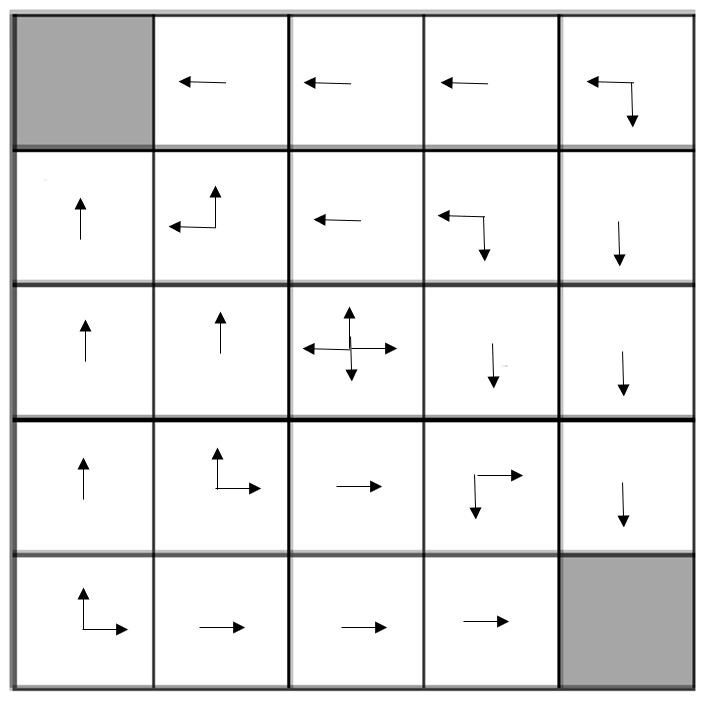

# 3. Implement tabular policy iteration and value iteration to and the optimal value
function and optimal policy. You could either choose to use this package or design your
own gridworld environment in python. <br>
(a) After every iteration (for every seed), run the estimated policy in the environment
for 5 test episodes and report the mean over (i) cumulative reward per episode
obtained by the agent, and (ii) the number of timesteps required to solve the task
per episode of experience, both reported over 5 different seeds. <br>
(b) Visualize the final policies obtained using both policy iteration and value iteration.
Are they similar to the optimal policy you expected in the second question of this
section?

Go see in the grid class for the implementation of the algorithm:

a) we are going to implement a new class. That will be in the grid. For this matter we are going to add the simulate function in the gridworld class.

In [ ]:
gridTest = Gridword([0,24],0.25,5,0.01)
gridTest.integrate_simulation()

Text(0, 0.5, 'Average reward')

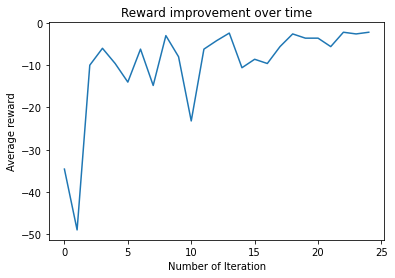

In [ ]:
size = len(gridTest.reward_by_iteration)

plt.plot( [x for x in range(size)],gridTest.reward_by_iteration )
plt.title("Reward improvement over time")
plt.xlabel("Number of Iteration")
plt.ylabel("Average reward")


Text(0, 0.5, 'Average reward')

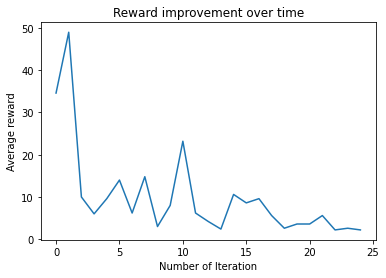

In [ ]:
plt.plot( [x for x in range(size)],gridTest.avg_step )
plt.title("Reward improvement over time")
plt.xlabel("Number of Iteration")
plt.ylabel("Number of step")


###We can see that the reward is increasing over time and the number of step is decreasing.

b) <br>
You can see the implementation of the task in the class Gridworld. As an exercice, I decide to model my own grid environment. This is how we can find the optimal policy using one of the two proposed algorithm.

In [ ]:
#We purposefully took a high convergence point to show that algorith is converging.
grid_iterative_policy = Gridword([0,24],0.25,5,5)
grid_iterative_policy.policy_iteration()
print("State Policies using iterative policy algorirthm")
grid_iterative_policy.print_policy()

State Policies using iterative policy algorirthm
-------------------------------------------
0 is a terminal state
-------------------------------------------
1 case can go to  West, 
-------------------------------------------
2 case can go to  West, 
-------------------------------------------
3 case can go to  West, 
-------------------------------------------
4 case can go to  South,  West, 
-------------------------------------------
5 case can go to  North, 
-------------------------------------------
6 case can go to  North,  West, 
-------------------------------------------
7 case can go to  West, 
-------------------------------------------
8 case can go to  South,  West, 
-------------------------------------------
9 case can go to  South, 
-------------------------------------------
10 case can go to  North, 
-------------------------------------------
11 case can go to  North, 
-------------------------------------------
12 case can go to  North,  East, South,  West, 
----

Here with the value iterative algorithm using the same condition.

In [ ]:
#Here we purposefully took the gridworld with the same parameter. As you can see, here the policy value has not converge yet.

grid_iterative_value = Gridword([0,24],0.25,5,5)
grid_iterative_value.value_iteration()
print("State Policies using iterative values algorirthm")
grid_iterative_value.print_policy()

State Policies using iterative values algorirthm
-------------------------------------------
0 is a terminal state
-------------------------------------------
1 case can go to  West, 
-------------------------------------------
2 case can go to  East, South,  West, 
-------------------------------------------
3 case can go to  East, South,  West, 
-------------------------------------------
4 case can go to  South,  West, 
-------------------------------------------
5 case can go to  North, 
-------------------------------------------
6 case can go to  North,  East, South,  West, 
-------------------------------------------
7 case can go to  North,  East, South,  West, 
-------------------------------------------
8 case can go to  North,  East, South,  West, 
-------------------------------------------
9 case can go to  North,  South,  West, 
-------------------------------------------
10 case can go to  North,  East, South, 
-------------------------------------------
11 case can go t

As you can see the here since we choose an higher converging point the policies are not the same. This is why when using the iterative value evaluation it is important to choose a small converging point.

In [ ]:
grid_iterative_value2 = Gridword([0,24],0.25,5,0.1)
grid_iterative_value2.value_iteration()
print("State Policies using iterative values algorirthm")
grid_iterative_value2.print_policy()

State Policies using iterative values algorirthm
-------------------------------------------
0 is a terminal state
-------------------------------------------
1 case can go to  West, 
-------------------------------------------
2 case can go to  West, 
-------------------------------------------
3 case can go to  West, 
-------------------------------------------
4 case can go to  South,  West, 
-------------------------------------------
5 case can go to  North, 
-------------------------------------------
6 case can go to  North,  West, 
-------------------------------------------
7 case can go to  West, 
-------------------------------------------
8 case can go to  South,  West, 
-------------------------------------------
9 case can go to  South, 
-------------------------------------------
10 case can go to  North, 
-------------------------------------------
11 case can go to  North, 
-------------------------------------------
12 case can go to  South,  West, 
------------------

The iterative value evaluation is giving a similar policy like the iterative policy one. However, if the treshold is becoming small we are some optimal policy options are disapearing. For example:

In [ ]:
grid_iterative_value3 = Gridword([0,24],0.25,5,0.0001)
grid_iterative_value3.value_iteration()
print("State Policies using iterative values algorirthm")
grid_iterative_value3.print_policy()

State Policies using iterative values algorirthm
-------------------------------------------
0 is a terminal state
-------------------------------------------
1 case can go to  West, 
-------------------------------------------
2 case can go to  West, 
-------------------------------------------
3 case can go to  West, 
-------------------------------------------
4 case can go to  West, 
-------------------------------------------
5 case can go to  North, 
-------------------------------------------
6 case can go to  North,  West, 
-------------------------------------------
7 case can go to  West, 
-------------------------------------------
8 case can go to  South, 
-------------------------------------------
9 case can go to  South, 
-------------------------------------------
10 case can go to  North, 
-------------------------------------------
11 case can go to  North, 
-------------------------------------------
12 case can go to  East, West, 
-----------------------------------

As you can see in the step 4 we have a missing option since the policy allows to go south and west but only goes West. This solution is acceptable considering the fact that with a $\Delta = 0.1$ We have the same policies has the iterative policy evaluation.

Now has you can see with a $\Delta = 0.1$. The policy is converging to the same policy has the first one. We need to be careful with more complex problem with the algorithm to choose. Depending on the situation some might be better.

For example, the if the treshold is not small enough  (in the iterative value evaluation algorithm) we might not find the optimal solution as we saw in the previous demonstration. However, it can be faster for longer problem to compute because there is no back in fourth between the evaluation step and the policy evaluation.

> Both of the algorithm gives the same policy manually found at the question 2.



The function simulate is taking random policy action until it converge. You can refer to the code in the gridword class.